In [66]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# General imports
import json
import os
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum
import matplotlib.pyplot as plt
import math

In [68]:
from component.sup_sys.algorithm_loader import load_algorithms
load_algorithms()

,Algorithm Type,Algorithm
0,ilp,MILQ_extend
1,ilp,MILQ_simple
2,ai,(none)
3,heuristic,SJFS


In [69]:
from component.a_backend.fake_backend import *
from component.sup_sys.backend_loader import load_backends
backendlist = load_backends()
print(backendlist)

{'FakeAlgiers': 27, 'FakeAlmadenV2': 20, 'FakeArmonkV2': 1, 'FakeAthensV2': 5, 'FakeAuckland': 27, 'FakeBelemV2': 5, 'FakeBoeblingenV2': 20, 'FakeBogotaV2': 5, 'FakeBrisbane': 127, 'FakeBrooklynV2': 65, 'FakeBurlingtonV2': 5, 'FakeCairoV2': 27, 'FakeCambridgeV2': 28, 'FakeCasablancaV2': 7, 'FakeCusco': 127, 'FakeEssexV2': 5, 'FakeFractionalBackend': 5, 'FakeGeneva': 27, 'FakeGuadalupeV2': 16, 'FakeHanoiV2': 27, 'FakeJakartaV2': 7, 'FakeJohannesburgV2': 20, 'FakeKawasaki': 127, 'FakeKolkataV2': 27, 'FakeKyiv': 127, 'FakeKyoto': 127, 'FakeLagosV2': 7, 'FakeLimaV2': 5, 'FakeLondonV2': 5, 'FakeManhattanV2': 65, 'FakeManilaV2': 5, 'FakeMarrakesh': 156, 'FakeMelbourneV2': 15, 'FakeMontrealV2': 27, 'FakeMumbaiV2': 27, 'FakeNairobiV2': 7, 'FakeOsaka': 127, 'FakeOslo': 7, 'FakeOurenseV2': 5, 'FakeParisV2': 27, 'FakePeekskill': 27, 'FakePerth': 7, 'FakePoughkeepsieV2': 20, 'FakePrague': 33, 'FakeQuebec': 127, 'FakeQuitoV2': 5, 'FakeRochesterV2': 53, 'FakeRomeV2': 5, 'FakeSantiagoV2': 5, 'FakeShe

{'fake_belem': <qiskit_ibm_runtime.fake_provider.backends.belem.fake_belem.FakeBelemV2 object at 0x748754ec4f40>, 'fake_manila': <qiskit_ibm_runtime.fake_provider.backends.manila.fake_manila.FakeManilaV2 object at 0x748754ec5630>}


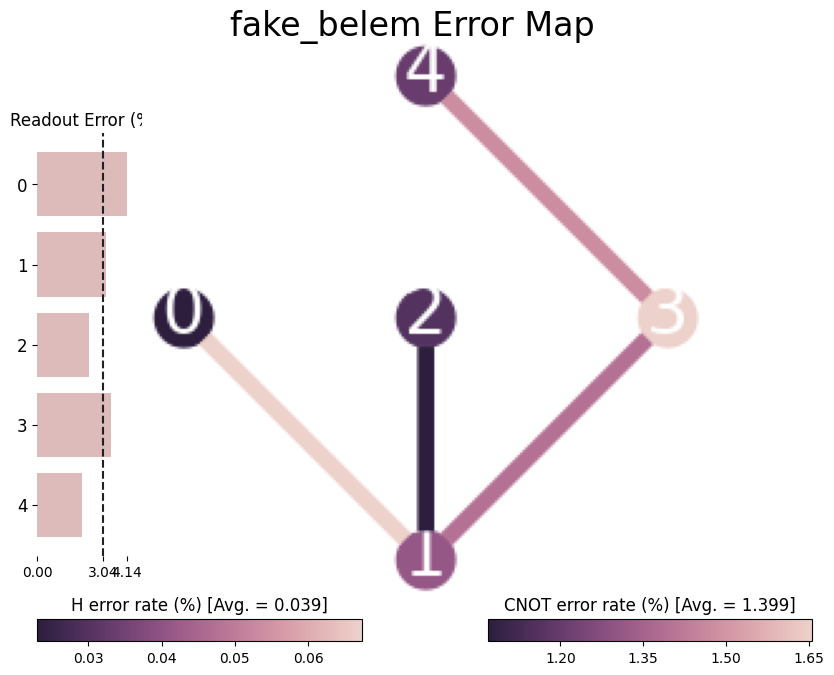

In [70]:
import matplotlib.pyplot as plt
from component.a_backend import fake_backend
from qiskit.visualization import plot_error_map

machines = {}
backend0 = FakeBelemV2()
backend1 = FakeManilaV2()

machines[backend0.name] = backend0
machines[backend1.name] = backend1
print(machines)
plot_error_map(list(machines.values())[0], figsize=(10, 8))

# Generate the problem

Create benchmark

In [71]:
jobs = {"1": 2, "2": 3, "3": 8, "4": 2 }

In [95]:
from component.b_benchmark.mqt_tool import benchmark_circuit
from component.sup_sys.job_info import JobInfo

origin_job_info = {}

for job_name, num_qubits in jobs.items():
    circuit = benchmark_circuit(name_algorithm="str", circuit_size=num_qubits)
    circuit.remove_final_measurements()
    origin_job_info[job_name] = JobInfo(
        job_name=job_name,
        qubits=circuit.num_qubits,
        machine=None,  # Placeholder for machine name
        capacity_machine=0,  # Placeholder for machine capacity
        start_time=0.0,  # Placeholder for start time
        duration=0.0,  # Placeholder for duration
        end_time=0.0,  # Placeholder for end time
        childrenJobs=None,  # Placeholder for child jobs
        circuit=circuit,
        result_cut=None,  # Placeholder for result cut
    )

for job in origin_job_info.values():
    job.print()

Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 1
Circuit:           ┌───┐
q_0: ─────┤ X ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
Qubits: 2
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Fidelity: None
Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 2
Circuit:                ┌───┐
q_0: ──────────┤ X ├
          ┌───┐└─┬─┘
q_1: ─────┤ X ├──■──
     ┌───┐└─┬─┘     
q_2: ┤ H ├──■───────
     └───┘          
Qubits: 3
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Fidelity: None
Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 3
Circuit:                                         ┌───┐
q_0: ───────────────────────────────────┤ X ├
                                   ┌───┐└─┬─┘
q_1: ──────────────────────────────┤ X ├──■──
                              ┌───┐└─┬─┘     
q_2: ──────────

Cutting circuit

In [73]:
# cutting each job into 2 parts in dict_job_info
process_job_info = origin_job_info.copy()
for job in process_job_info.values():
    job.print()

Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 1
Circuit:           ┌───┐
q_0: ─────┤ X ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
Qubits: 2
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Fidelity: None
Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 2
Circuit:                ┌───┐
q_0: ──────────┤ X ├
          ┌───┐└─┬─┘
q_1: ─────┤ X ├──■──
     ┌───┐└─┬─┘     
q_2: ┤ H ├──■───────
     └───┘          
Qubits: 3
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Fidelity: None
Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 3
Circuit:                                         ┌───┐
q_0: ───────────────────────────────────┤ X ├
                                   ┌───┐└─┬─┘
q_1: ──────────────────────────────┤ X ├──■──
                              ┌───┐└─┬─┘     
q_2: ──────────

cal value from backend

In [101]:
# Cutting the jobs into two parts with condition in process_job_info
from component.c_circuit_work.cutting.width_c import *

max_width = max(list(machines.values()), key=lambda x: x.num_qubits).num_qubits

for job_name, job_info in process_job_info.items():
    if job_info.qubits > max_width:
        job_info.childrenJobs = []
        cut_name, observable = greedy_cut(job_info.circuit, max_width)
        print(observable)
        result_cut = gate_to_reduce_width(job_info.circuit, cut_name, observable)
        for i, (subcircuit_name, subcircuit) in enumerate(result_cut.subcircuits.items()):
            job_info.childrenJobs.append(
                JobInfo(
                    job_name=f"{job_name}_{i+1}",
                    qubits=subcircuit.num_qubits,
                    machine=None,
                    capacity_machine=0,
                    start_time=0.0,
                    duration=0.0,
                    end_time=0.0,
                    childrenJobs=None,
                    circuit=subcircuit,
                    result_cut=None,
                )
            )
        job_info.result_cut = result_cut
    job_info.print()

Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 1
Circuit:              ┌───┐ ░ ┌─┐   
   q_0: ─────┤ X ├─░─┤M├───
        ┌───┐└─┬─┘ ░ └╥┘┌─┐
   q_1: ┤ H ├──■───░──╫─┤M├
        └───┘      ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 
Qubits: 2
Machine: fake_manila
Capacity Machine: 5
Start Time: 0.0
Duration: 8.0
End Time: 8.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: global phase: π/4
                ┌────────────────┐                 ┌───┐
      q_0 -> 0 ─┤ Delay(160[dt]) ├─────────────────┤ X ├
                └──┬─────────┬───┘┌────┐┌─────────┐└─┬─┘
      q_1 -> 1 ────┤ Rz(π/2) ├────┤ √X ├┤ Rz(π/2) ├──■──
               ┌───┴─────────┴───┐└────┘└─────────┘     
ancilla_0 -> 2 ┤ Delay(1568[dt]) ├──────────────────────
               ├─────────────────┤                      
ancilla_1 -> 3 ┤ Delay(1568[dt]) ├──────────────────────
               ├─────────────────┤                      
ancilla_2 -> 4 ┤ Delay(1568[dt]) ├─────────────────────

In [105]:

# 4. Run subexperiments on a quantum backend
for job_name, job_info in process_job_info.items():
    if job_info.result_cut is not None:
        result_cut = job_info.result_cut
        backend = list(machines.values())[0] # Example backend
        results = run_subexperiments(result_cut.subexperiments, backend)
        print(job_info.circuit)
        print(result_cut.observable)
        reconstructed_expval, exact_expval, error_estimation, relative_error_estimation = compute_expectation_value(results, result_cut.coefficients, result_cut.subobservables, result_cut.observable, job_info.circuit)
        print_results(reconstructed_expval, exact_expval, error_estimation, relative_error_estimation)

                                        ┌───┐
q_0: ───────────────────────────────────┤ X ├
                                   ┌───┐└─┬─┘
q_1: ──────────────────────────────┤ X ├──■──
                              ┌───┐└─┬─┘     
q_2: ─────────────────────────┤ X ├──■───────
                         ┌───┐└─┬─┘          
q_3: ────────────────────┤ X ├──■────────────
                    ┌───┐└─┬─┘               
q_4: ───────────────┤ X ├──■─────────────────
               ┌───┐└─┬─┘                    
q_5: ──────────┤ X ├──■──────────────────────
          ┌───┐└─┬─┘                         
q_6: ─────┤ X ├──■───────────────────────────
     ┌───┐└─┬─┘                              
q_7: ┤ H ├──■────────────────────────────────
     └───┘                                   
SparsePauliOp(['IIIIIIII'],
              coeffs=[1.+0.j])
Reconstructed expectation value: 0.99186198
Exact expectation value: 1.0
Error in estimation: 0.00813802
Relative error in estimation: 0.00813802


Apply scheduling to the benchmark circuits as require ment

In [76]:
# Get the job for run scheduler

scheduler_job = {}
def get_scheduler_jobs(job_info):
    if job_info.childrenJobs is None:
        return {job_info.job_name: job_info}
    scheduler_jobs = {}
    for child_job in job_info.childrenJobs:
        scheduler_jobs.update(get_scheduler_jobs(child_job))
    return scheduler_jobs

for job_name, job_info in process_job_info.items():
    scheduler_job.update(get_scheduler_jobs(job_info))
    
print("Scheduler Jobs:")
for job_name, job_info in scheduler_job.items():
    job_info.print()

Scheduler Jobs:
Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 1
Circuit:           ┌───┐
q_0: ─────┤ X ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
Qubits: 2
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Fidelity: None
Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 2
Circuit:                ┌───┐
q_0: ──────────┤ X ├
          ┌───┐└─┬─┘
q_1: ─────┤ X ├──■──
     ┌───┐└─┬─┘     
q_2: ┤ H ├──■───────
     └───┘          
Qubits: 3
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Fidelity: None
Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 3_1
Circuit:                                 ┌───┐
q43_0: ─────────────────────────┤ X ├
                           ┌───┐└─┬─┘
q43_1: ────────────────────┤ X ├──■──
                      ┌───┐└─┬─┘     
q43_2: ───────────────┤ X ├──■───────

In [54]:
# Setup
bigM = 1000000
timesteps = 2**5
jobs = ["0"] + list(scheduler_job.keys())
job_capacities = {"0": 0}
job_capacities.update({job_name: job_info.qubits for job_name, job_info in scheduler_job.items()})
machines_ilp = list(machines.keys())  # Keep machines as a list of keys
machine_capacities_ilp = {machine_name: machines[machine_name].num_qubits for machine_name in machines}
print("Jobs:", jobs)
print("Job Capacities:", job_capacities)
print("Machines:", machines_ilp)
print("Machine Capacities:", machine_capacities_ilp)
from component.d_scheduling.algorithm.ilp.MILQ_extend import MILQ_extend_implementation
# Scheduler
MILQ_extend_implementation.example_problem(bigM, timesteps, "component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result", jobs, job_capacities, machines_ilp, machine_capacities_ilp)

Jobs: ['0', '1', '2', '3_1', '3_2', '4']
Job Capacities: {'0': 0, '1': 2, '2': 3, '3_1': 5, '3_2': 3, '4': 2}
Machines: ['fake_belem', 'fake_manila']
Machine Capacities: {'fake_belem': 5, 'fake_manila': 5}
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/trieu/anaconda3/envs/squan/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/1c81eab1545a456a9035e4e8bf3bcfd8-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/1c81eab1545a456a9035e4e8bf3bcfd8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 985 COLUMNS
At line 6778 RHS
At line 7759 BOUNDS
At line 8510 ENDATA
Problem MODEL has 980 rows, 762 columns and 4291 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8.95151 - 0.00 seconds
Cgl0002I 10 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 554 strengthened rows, 0 substitutions
Cgl0003I

Saved job data to: /home/trieu/D/Quantum_Repo/Quantum_Simulation_Scheduling/component/d_scheduling/algorithm/ilp/MILQ_extend/job_data.txt
Saved job data as JSON to: /home/trieu/D/Quantum_Repo/Quantum_Simulation_Scheduling/component/d_scheduling/algorithm/ilp/MILQ_extend/job_data.json
   job  qubits      machine  capacity  start   end  duration
0    1       2  fake_manila         5    0.0   8.0       8.0
1    2       3  fake_manila         5    0.0   9.0       9.0
2  3_1       5   fake_belem         5    0.0  21.0      21.0
3  3_2       3  fake_manila         5    9.0  23.0      14.0
4    4       2  fake_manila         5    8.0  23.0      15.0
Saved plot to: /home/trieu/D/Quantum_Repo/Quantum_Simulation_Scheduling/component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result_plot.pdf


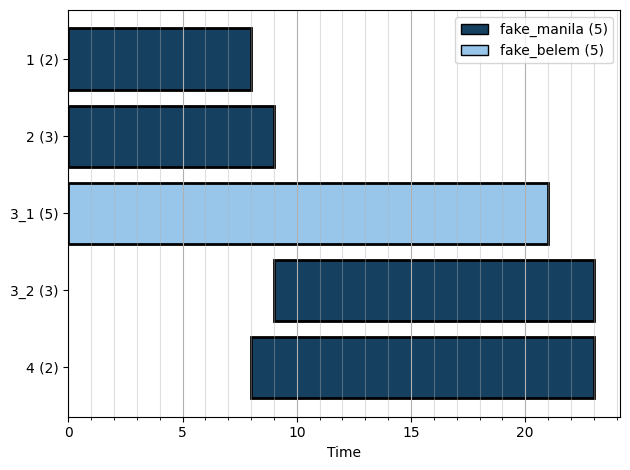

In [56]:
# Visualize
from component.d_scheduling.visualize import ilp

ilp.visualize("component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result.json")

In [77]:
from component.d_scheduling.analyze import analyze_cal

data = analyze_cal.load_job_data("component/d_scheduling/algorithm/ilp/MILQ_extend/job_data.txt")
print(data)

for job_data in data:
    job_name = job_data['job']
    if job_name in scheduler_job:
        scheduler_job[job_name].qubits = job_data['qubits']
        scheduler_job[job_name].machine = job_data['machine']
        scheduler_job[job_name].capacity_machine = job_data['capacity']
        scheduler_job[job_name].start_time = job_data['start']
        scheduler_job[job_name].duration = job_data['duration']
        scheduler_job[job_name].end_time = job_data['end']

print("Scheduler Jobs with Scheduling Information:")
for job_name, job_info in scheduler_job.items():
    job_info.print()


[{'job': '1', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 8.0, 'duration': 8.0}, {'job': '2', 'qubits': 3, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 9.0, 'duration': 9.0}, {'job': '3_1', 'qubits': 5, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.0, 'end': 21.0, 'duration': 21.0}, {'job': '3_2', 'qubits': 3, 'machine': 'fake_manila', 'capacity': 5, 'start': 9.0, 'end': 23.0, 'duration': 14.0}, {'job': '4', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 8.0, 'end': 23.0, 'duration': 15.0}]
Scheduler Jobs with Scheduling Information:
Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 1
Circuit:           ┌───┐
q_0: ─────┤ X ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
Qubits: 2
Machine: fake_manila
Capacity Machine: 5
Start Time: 0.0
Duration: 8.0
End Time: 8.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Fidelity: None
Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 2
Circuit:        

In [78]:
from qiskit import QuantumCircuit, transpile
# Transpile circuits for all scheduled jobs
for job_id, job in scheduler_job.items():
    backend = machines.get(job.machine)
    if backend:
        # Perform transpilation
        job.circuit.data = [hasChange for hasChange in job.circuit.data if hasChange.operation.name != "qpd_1q"]
        job.transpiled_circuit = transpile(job.circuit, backend, scheduling_method='alap', layout_method='trivial')
        job.circuit.measure_all()
        job.transpiled_circuit_measured = transpile(job.circuit, backend, scheduling_method='alap', layout_method='trivial')
    else:
        print(f"No backend found for machine {job.machine}. Skipping job {job_id}.")
        
    job.print()

Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 1
Circuit:              ┌───┐ ░ ┌─┐   
   q_0: ─────┤ X ├─░─┤M├───
        ┌───┐└─┬─┘ ░ └╥┘┌─┐
   q_1: ┤ H ├──■───░──╫─┤M├
        └───┘      ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 
Qubits: 2
Machine: fake_manila
Capacity Machine: 5
Start Time: 0.0
Duration: 8.0
End Time: 8.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: global phase: π/4
                ┌────────────────┐                 ┌───┐
      q_0 -> 0 ─┤ Delay(160[dt]) ├─────────────────┤ X ├
                └──┬─────────┬───┘┌────┐┌─────────┐└─┬─┘
      q_1 -> 1 ────┤ Rz(π/2) ├────┤ √X ├┤ Rz(π/2) ├──■──
               ┌───┴─────────┴───┐└────┘└─────────┘     
ancilla_0 -> 2 ┤ Delay(1568[dt]) ├──────────────────────
               ├─────────────────┤                      
ancilla_1 -> 3 ┤ Delay(1568[dt]) ├──────────────────────
               ├─────────────────┤                      
ancilla_2 -> 4 ┤ Delay(1568[dt]) ├─────────────────────

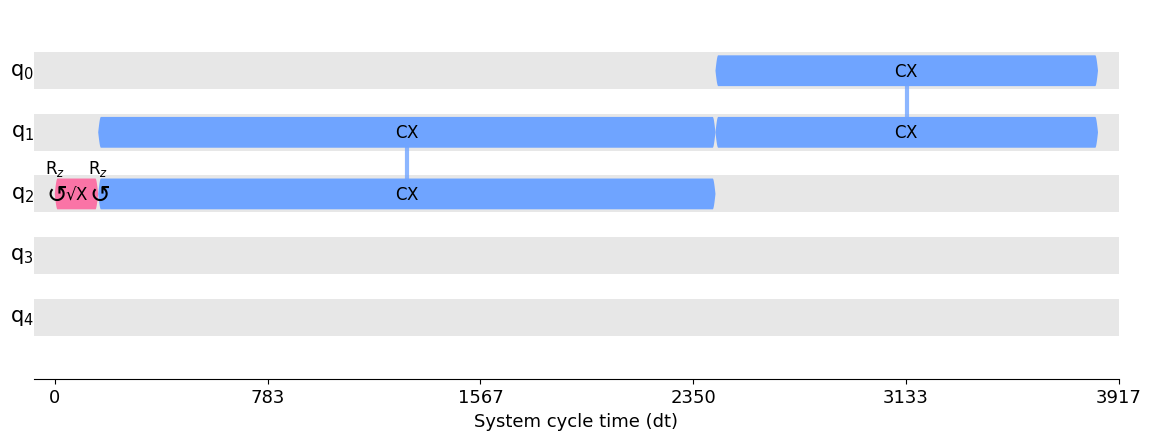

In [63]:
from qiskit.visualization.timeline import draw, IQXDebugging
draw(scheduler_job['3_2'].transpiled_circuit, target=machines['fake_belem'].target)

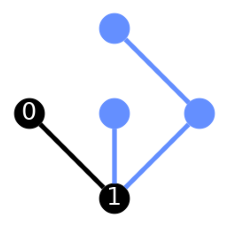

In [64]:
# after have the circuit we connect to
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(scheduler_job['1'].transpiled_circuit, machines['fake_belem'])

In [123]:
print(data)

[{'job': '1', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 25648.0, 'duration': 25648}, {'job': '2', 'qubits': 3, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 27920.0, 'duration': 27920}, {'job': '3', 'qubits': 5, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.0, 'end': 39280.0, 'duration': 39280}, {'job': '4', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 25648.0, 'end': 51296.0, 'duration': 25648}]


# Allow multithreading

In [134]:
import random

# Define the jobs
jobs = data.copy()

# Generate unique execution times
def get_the_duration_from_transpiled_circuit(circuit):
    return circuit.duration

# Simulate the scheduling with parallel execution support
def simulate_scheduling(jobs):
    machine_schedules = {'fake_belem': [], 'fake_manila': []}  # Track active jobs for each machine
    jobs = sorted(jobs, key=lambda x: x['start'])  # Sort jobs by start time
    for job in jobs:
        machine = job['machine']
        base_duration = job['duration']
        unique_duration = get_the_duration_from_transpiled_circuit(scheduler_job[job['job']].transpiled_circuit)

        # Find the earliest time the job can start
        current_schedule = machine_schedules[machine]
        start_time = job['start']
        
        # Check for parallel execution
        while True:
            # Filter out completed jobs
            active_jobs = [j for j in current_schedule if j['end'] > start_time]
            
            # Calculate total qubits in use
            total_qubits_in_use = sum(j['qubits'] for j in active_jobs)
            if total_qubits_in_use + job['qubits'] <= job['capacity']:
                # Enough resources are available
                break
            # Increment start_time to the earliest end time of active jobs
            start_time = min(j['end'] for j in active_jobs)

        # Update job start, end times, and duration
        job['start'] = start_time
        job['end'] = start_time + unique_duration
        job['duration'] = unique_duration

        # Add job to the machine's schedule
        current_schedule.append(job)

    return jobs

# Run the simulation
updated_jobs = simulate_scheduling(jobs)

# Print the updated schedule
for job in updated_jobs:
    print(job)


{'job': '1', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 25648.0, 'duration': 25648}
{'job': '2', 'qubits': 3, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 27920.0, 'duration': 27920}
{'job': '3', 'qubits': 5, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.0, 'end': 39280.0, 'duration': 39280}
{'job': '4', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 25648.0, 'end': 51296.0, 'duration': 25648}


/tmp/ipykernel_385912/598238853.py:8: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  return circuit.duration


# Don't allow multithreading

In [136]:
import random

# Define the jobs
jobs = data.copy()

# Generate unique execution times
def get_the_duration_from_transpiled_circuit(circuit):
    return circuit.duration

# Simulate the scheduling with parallel execution support
# Simulate the scheduling with parallel execution support
def simulate_scheduling(jobs):
    machine_current = {'fake_belem': [], 'fake_manila': []}  # Track active jobs for each machine
    
    ready_queue = {'fake_belem': [], 'fake_manila': []}  # Jobs ready to be executed on each machine
    
    # update job with unique execution times
    for job in jobs:
        job['duration'] = get_the_duration_from_transpiled_circuit(scheduler_job[job['job']].transpiled_circuit)
        job['end'] = job['start'] + job['duration']
    
    # Schedule jobs on each machine
    jobs_QUITO = [job for job in jobs if job['machine'] == 'fake_belem']
    jobs_MANILA = [job for job in jobs if job['machine'] == 'fake_manila']
    
    current_time_QUITO = 0.0
    current_time_BELEM = 0.0
    current_capacity_QUITO = 5
    current_capacity_BELEM = 5
    
    # Schedule jobs on QUITO machine
    while jobs_QUITO:
        # Check if there are any jobs ready to be executed
        for job in jobs_QUITO[:]:  # Iterate over a copy to allow modification
            if job['start'] <= current_time_QUITO and job['qubits'] <= current_capacity_QUITO:
                ready_queue['fake_belem'].append(job)
                current_capacity_QUITO -= job['qubits']
        
        # Execute jobs in the ready queue in parallel
        if ready_queue['fake_belem']:
            max_end_time = current_time_QUITO
            for job in ready_queue['fake_belem']:
                job['start'] = current_time_QUITO
                job['end'] = job['start'] + job['duration']
                max_end_time = max(max_end_time, job['end'])
                current_capacity_QUITO += job['qubits']
                jobs_QUITO.remove(job)
                machine_current['fake_belem'].append(job)
            ready_queue['fake_belem'] = []
            # Move the current time to the end of the last job in parallel
            current_time_QUITO = max_end_time
        else:
            # If no jobs are ready, move to the next time step
            current_time_QUITO += 1.0
        
    # Schedule jobs on BELEM machine
    while jobs_MANILA:
        # Check if there are any jobs ready to be executed
        for job in jobs_MANILA[:]:  # Iterate over a copy to allow modification
            if job['start'] <= current_time_BELEM and job['qubits'] <= current_capacity_BELEM:
                ready_queue['fake_manila'].append(job)
                current_capacity_BELEM -= job['qubits']
        
        # Execute jobs in the ready queue in parallel
        if ready_queue['fake_manila']:
            max_end_time = current_time_BELEM
            for job in ready_queue['fake_manila']:
                job['start'] = current_time_BELEM
                job['end'] = job['start'] + job['duration']
                max_end_time = max(max_end_time, job['end'])
                current_capacity_BELEM += job['qubits']
                jobs_MANILA.remove(job)
                machine_current['fake_manila'].append(job)
            ready_queue['fake_manila'] = []
            # Move the current time to the end of the last job in parallel
            current_time_BELEM = max_end_time
        else:
            # If no jobs are ready, move to the next time step
            current_time_BELEM += 1.0
    
    # Print the final schedule
    print("Final Schedule:")
    return machine_current
        
# Run the simulation
updated_jobs = simulate_scheduling(jobs)
# Print the updated schedule
for machine, scheduled_jobs in updated_jobs.items():
    print(f"Machine {machine}:")
    for job in scheduled_jobs:
        print(job)  

Final Schedule:
Machine fake_belem:
{'job': '3', 'qubits': 5, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.0, 'end': 39280.0, 'duration': 39280}
Machine fake_manila:
{'job': '1', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 25648.0, 'duration': 25648}
{'job': '2', 'qubits': 3, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 27920.0, 'duration': 27920}
{'job': '4', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 27920.0, 'end': 53568.0, 'duration': 25648}


/tmp/ipykernel_385912/1230890670.py:8: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  return circuit.duration


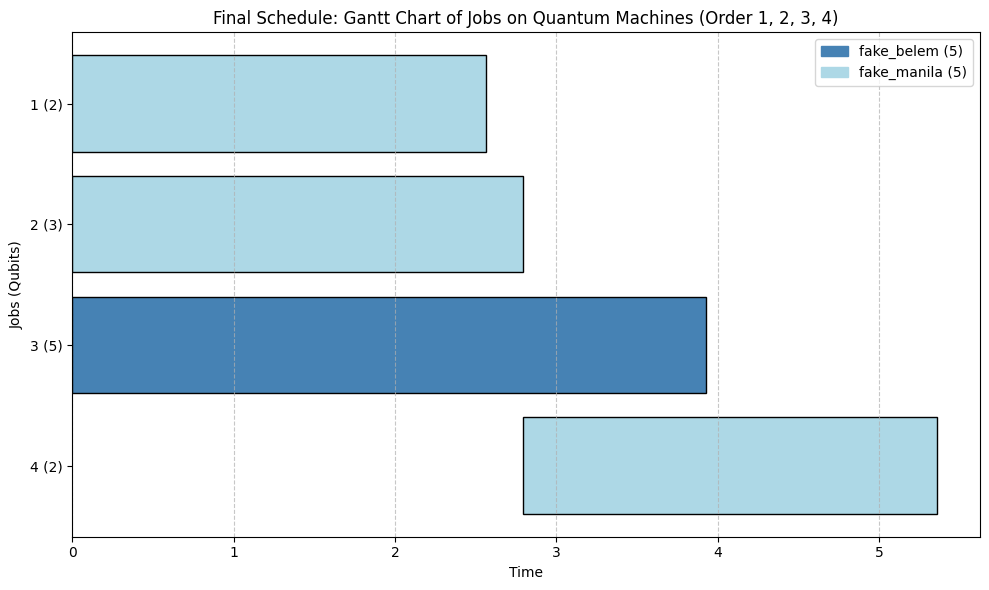

In [138]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Data
jobs = [
    {'job': '3', 'qubits': 5, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.0, 'end': 39280.0, 'duration': 39280},
    {'job': '1', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 25648.0, 'duration': 25648},
    {'job': '2', 'qubits': 3, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 27920.0, 'duration': 27920},
    {'job': '4', 'qubits': 2, 'machine': 'fake_manila', 'capacity': 5, 'start': 27920.0, 'end': 53568.0, 'duration': 25648},
]

# Normalize time to seconds (convert to a smaller scale for visualization)
for job in jobs:
    job['start'] /= 10000
    job['end'] /= 10000
    job['duration'] /= 10000

# Sort jobs by job ID (to enforce vertical order 1, 2, 3, 4)
jobs.sort(key=lambda x: int(x['job']))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each machine
colors = {
    'fake_belem': 'steelblue',
    'fake_manila': 'lightblue'
}

# Creating patches for legend
patches = [
    mpatches.Patch(color='steelblue', label='fake_belem (5)'),
    mpatches.Patch(color='lightblue', label='fake_manila (5)')
]

# Add jobs to the Gantt chart
for job in jobs:
    ax.barh(
        y=f"{job['job']} ({job['qubits']})", 
        width=job['duration'], 
        left=job['start'], 
        color=colors[job['machine']], 
        edgecolor='black'
    )

# Reverse the y-axis
ax.invert_yaxis()

# Add legend
ax.legend(handles=patches, loc='upper right')

# Labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Jobs (Qubits)")
ax.set_title("Final Schedule: Gantt Chart of Jobs on Quantum Machines (Order 1, 2, 3, 4)")

# Grid and layout adjustments
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

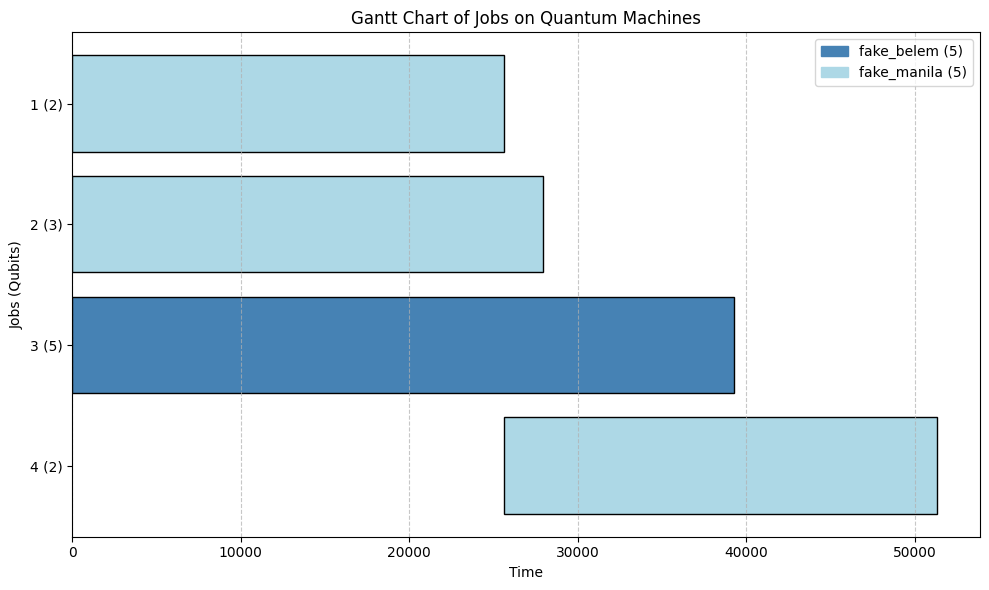

In [135]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each machine
colors = {
    'fake_belem': 'steelblue',
    'fake_manila': 'lightblue'
}

# Creating patches for legend
patches = [
    mpatches.Patch(color='steelblue', label='fake_belem (5)'),
    mpatches.Patch(color='lightblue', label='fake_manila (5)')
]

# Add jobs to the Gantt chart
for i, job in enumerate(updated_jobs):
    ax.barh(
        y=f"{job['job']} ({job['qubits']})", 
        width=job['duration'], 
        left=job['start'], 
        color=colors[job['machine']], 
        edgecolor='black'
    )

# Reverse the y-axis
ax.invert_yaxis()

# Add legend
ax.legend(handles=patches, loc='upper right')

# Labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Jobs (Qubits)")
ax.set_title("Gantt Chart of Jobs on Quantum Machines")

# Grid and layout adjustments
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

In [139]:
metrics = analyze_cal.calculate_metrics(data)
analyze_cal.print_metrics(metrics)


=== Metrics ===
Waiting Time: 27920.0
Response Time: 146416.0
Makespan: 53568.0
Throughput: 0.0001
Utilization on machine fake_manila: 0.6958
Utilization on machine fake_belem: 0.7333
Average Utilization: 0.7145


assemble the circuit to have the output in backend and ideal

In [79]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_distribution
import qiskit.quantum_info as qi
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2
from component.f_assemble.assemble_work import fidelity_from_counts

aer_simulator = AerSimulator()
for job_name, job_info in scheduler_job.items():
    backend = machines.get(job_info.machine)
    
    if backend:
        transpiled_circuit = job_info.transpiled_circuit_measured
        
        # Run the ideal simulation
        ideal_result = aer_simulator.run(transpiled_circuit, shots=1024).result()
        ideal_counts = ideal_result.get_counts(transpiled_circuit)
        
        # Run circuit on the simulated backend
        job = SamplerV2(backend).run([transpiled_circuit], shots=1024)
        sim_result = job.result()[0]
        sim_counts = sim_result.data.meas.get_counts()
        
        # Calculate fidelity
        fidelity_val, rho_ideal, rho_sim = fidelity_from_counts(ideal_counts, sim_counts)
        
        # Store the fidelity values
        job_info.fidelity = fidelity_val
        
    job_info.print()

Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 1
Circuit:              ┌───┐ ░ ┌─┐   
   q_0: ─────┤ X ├─░─┤M├───
        ┌───┐└─┬─┘ ░ └╥┘┌─┐
   q_1: ┤ H ├──■───░──╫─┤M├
        └───┘      ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 
Qubits: 2
Machine: fake_manila
Capacity Machine: 5
Start Time: 0.0
Duration: 8.0
End Time: 8.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: global phase: π/4
                ┌────────────────┐                 ┌───┐
      q_0 -> 0 ─┤ Delay(160[dt]) ├─────────────────┤ X ├
                └──┬─────────┬───┘┌────┐┌─────────┐└─┬─┘
      q_1 -> 1 ────┤ Rz(π/2) ├────┤ √X ├┤ Rz(π/2) ├──■──
               ┌───┴─────────┴───┐└────┘└─────────┘     
ancilla_0 -> 2 ┤ Delay(1568[dt]) ├──────────────────────
               ├─────────────────┤                      
ancilla_1 -> 3 ┤ Delay(1568[dt]) ├──────────────────────
               ├─────────────────┤                      
ancilla_2 -> 4 ┤ Delay(1568[dt]) ├─────────────────────

In [82]:
for job_name, job_info in origin_job_info.items():
    job_info.print()

Job ID: 77bf41f6-d268-4ce5-8544-5eb023e39e5d
Job Name: 1
Circuit:              ┌───┐ ░ ┌─┐   
   q_0: ─────┤ X ├─░─┤M├───
        ┌───┐└─┬─┘ ░ └╥┘┌─┐
   q_1: ┤ H ├──■───░──╫─┤M├
        └───┘      ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 
Qubits: 2
Machine: fake_manila
Capacity Machine: 5
Start Time: 0.0
Duration: 8.0
End Time: 8.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: global phase: π/4
                ┌────────────────┐                 ┌───┐
      q_0 -> 0 ─┤ Delay(160[dt]) ├─────────────────┤ X ├
                └──┬─────────┬───┘┌────┐┌─────────┐└─┬─┘
      q_1 -> 1 ────┤ Rz(π/2) ├────┤ √X ├┤ Rz(π/2) ├──■──
               ┌───┴─────────┴───┐└────┘└─────────┘     
ancilla_0 -> 2 ┤ Delay(1568[dt]) ├──────────────────────
               ├─────────────────┤                      
ancilla_1 -> 3 ┤ Delay(1568[dt]) ├──────────────────────
               ├─────────────────┤                      
ancilla_2 -> 4 ┤ Delay(1568[dt]) ├─────────────────────